# Image captioning using Keras - Train

In [1]:
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical

### Feature Extraction of Images

We will be using MobileNetV2 to obtain the features vectors of the images. More information on MobileNetV2 can be found [here](https://keras.io/api/applications/mobilenet/#mobilenetv2-function).

In [2]:
model = keras.applications.MobileNetV2()
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [32]:
model2 = Model(model.input, model.layers[-2].output)

### Laod the pre-processed images

In [4]:
w2s = np.load('word2seq.npy',allow_pickle='TRUE').item()
s2w = np.load('seq2word.npy',allow_pickle='TRUE').item()

encoder_input = np.load('encoder_input.npy')
decoder_stuff = np.load('decoder_stuff.npy')

 total number of images : 8091 
 total number of captions : 40455 

['ST', 'a', 'man', 'uses', 'ice', 'picks', 'and', 'crampons', 'to', 'scale', 'ice', '.', '', 'ET', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


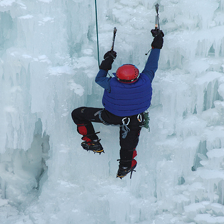

In [35]:
print(' total number of images :',len(encoder_input),'\n','total number of captions :',len(decoder_stuff),'\n')
lis = []

for i in decoder_stuff[105] : # Each image has 5 corresponding captions. So 21*5 = 105
    lis.append(s2w[i])
    
print(lis)

tf.keras.preprocessing.image.array_to_img(encoder_input[21])

### Use MobileNetV2 to get the feature vectors

In [6]:
feat_vect = []
for i in range(len(encoder_input)):
    feat_vect.append([model2.predict(encoder_input[i].reshape((1,224,224,3)))])

    feat_vect_stacked = np.stack(feat_vect)

Duplicate every image 4 times, as each image has 5 captions.

In [8]:
feat_vect_stacked_duplicated = []

for i in range(len(feat_vect_stacked)):
    for j in range(5):
        feat_vect_stacked_duplicated.append(feat_vect_stacked[i])
        
feat_vect_stacked_duplicated_stacked = np.stack(feat_vect_stacked_duplicated)

In [9]:
feat_vect_stacked_duplicated_stacked.shape

(40455, 1, 1, 1280)

In [11]:
feat_vect_final = feat_vect_stacked_duplicated_stacked.reshape((40455,1,1280))

In [12]:
decoder_input = []
decoder_output = []

for i in range(len(decoder_stuff)):
    decoder_input.append(decoder_stuff[i][:-1])
    decoder_output.append(decoder_stuff[i][1:])

decoder_input = np.stack(decoder_input)
decoder_output = np.stack(decoder_output)

### Build Model

Will be using functional API of Keras. The model's architecture can be found in the README. <br />
Feel free to tune the hyper parameters.

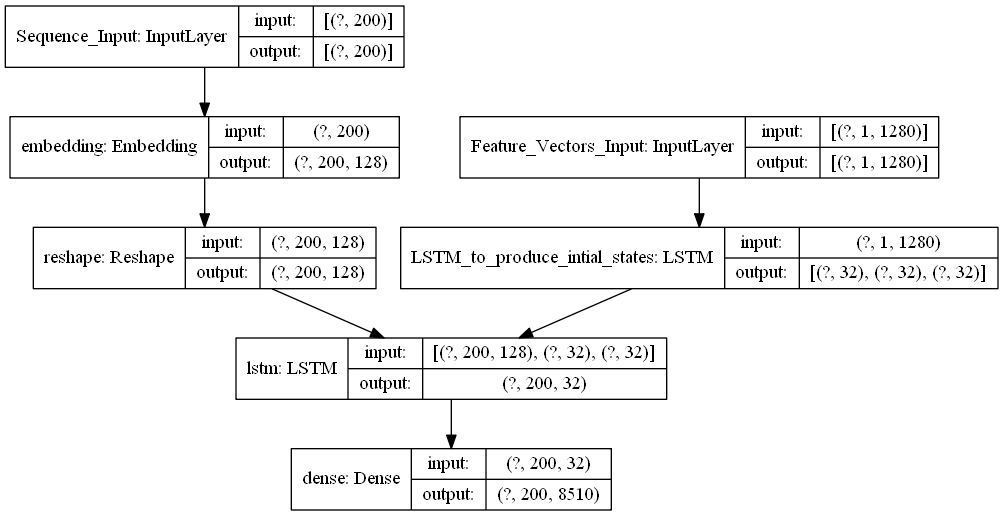

In [16]:
# Input layer for the images
img_inp = keras.Input(shape = (1,1280), name = 'Feature_Vectors_Input') # 1280 --> length of feature vector
LSTM_img = keras.layers.LSTM(units = 16, return_state = True, name = 'LSTM_to_produce_intial_states')

# When I tried states = LSTM_img.states it threw an error when re-using the states in the layer LSTM_decod.
flag1, s1, s2 = LSTM_img(img_inp) 
states = [s1,s2]

# Input layer for the sequence
inp = keras.Input(shape = (200), name = 'Sequence_Input')

Embed_layer = keras.layers.Embedding(input_dim = len(w2s), output_dim = 128)
embedded = Embed_layer(inp)

reshaped = keras.layers.Reshape((200,128))(embedded)

# Setting return_sequence = true returns the whole prediction instead of the last prediction alone
LSTM_decod = keras.layers.LSTM(units = 16, return_sequences = True)(reshaped, initial_state = states) 

Densed = keras.layers.Dense(units = len(w2s), activation = 'softmax')(LSTM_decod)

captioning_model = Model([img_inp,inp],Densed)

plot_model(captioning_model, show_shapes=True, show_layer_names=True)

In [27]:
captioning_model.compile(optimizer = 'adam', 
                         loss = 'sparse_categorical_crossentropy', 
                         metrics = ['sparse_categorical_accuracy'])

hist = captioning_model.fit([feat_vect_final, decoder_input], decoder_output, epochs = 3, validation_split = 0.3)

Epoch 1/3
885/885 [==============================] - 1894s 2s/step - loss: 0.8933 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.3312 - val_sparse_categorical_accuracy: 0.9468
Epoch 2/3
885/885 [==============================] - 1823s 2s/step - loss: 0.3030 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.2890 - val_sparse_categorical_accuracy: 0.9541
Epoch 3/3
885/885 [==============================] - 1834s 2s/step - loss: 0.2734 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.2674 - val_sparse_categorical_accuracy: 0.9558


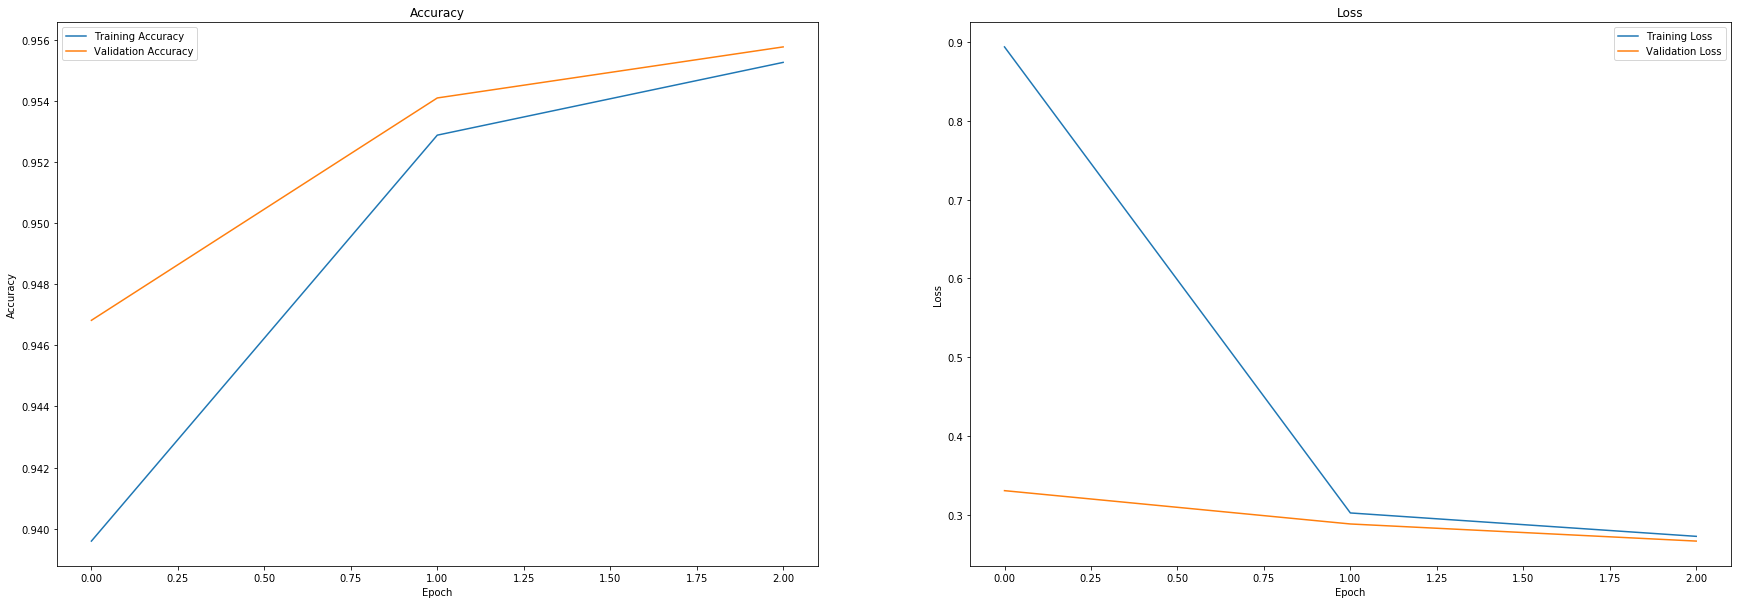

In [30]:
fig=plt.subplots(figsize=(30,10))

plt.subplot(1,2,1)
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.show()

In [31]:
captioning_model.save_weights('Caption_Image.h5')